In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "eng"

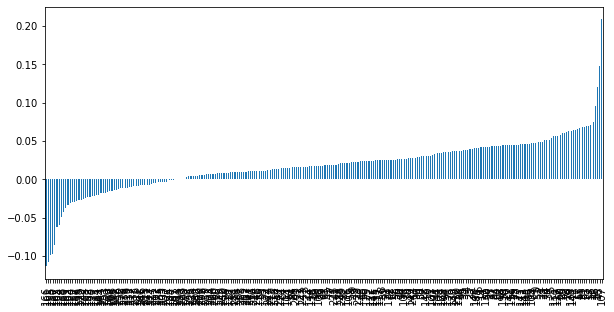

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores, read_sentiart_textblob_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)
labels = read_sentiart_textblob_scores(sentiment_dir, canonization_labels_dir, lang)
senti_tool = "sentiscore_average"
labels = labels[["book_name","sentiscore_average"]]
labels = labels.rename(columns={"sentiscore_average": "y"})

In [3]:
labels

,book_name,y
0,Ainsworth_William-Harrison_Rookwood_1834,-0.097343
1,Anonymous_Anonymous_The-Adventures-of-Anthony-...,0.002943
3,Austen_Jane_Pride-and-Prejudice_1813,0.045825
4,Austen_Jane_Sense-and-Sensibility_1811,0.030519
5,Ballantyne_Robert_The-Coral-Island_1858,-0.031421
...,...,...
248,Wells_H-G_The-World-Set-Free_1914,0.010914
249,Wells_H-G_Tono-Bungay_1909,0.006893
250,Wilde_Oscar_The-Picture-of-Dorian-Gray_1890,0.007171
251,Wollstonecraft_Mary_Mary_1788,-0.007740


197


<AxesSubplot:ylabel='Frequency'>

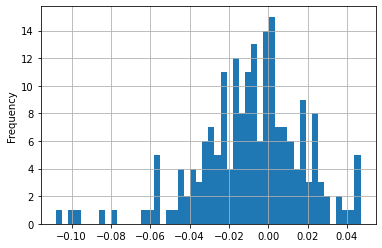

In [4]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [5]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        if "c" in self.labels.columns: 
            labels = self.labels.drop(columns="c")
        else:
            labels = self.labels
        return labels

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + '-' + senti_tool + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + '-' + senti_tool + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value


In [6]:
# '''
# Classification into reviewed/not reviewed
# '''

# class TwoclassClassification(Regression):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
#     def _prepare_labels(self):
#         labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
#         return labels
        
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         agg_labels = self.labels[["book_name"]].drop_duplicates()
#         agg_labels["y"] = 1
#         df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review)
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _get_sample_weights(self, df):
#         # Weights for calculating accuracy 
#         chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
#         chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
#         chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
#         df = df.merge(right=chunks_per_book, how="left", on="book_name")
#         sample_weights = df["chunks_per_book"].tolist()
#         return sample_weights
    
#     def _aggregate_chunk_predictions(self, df):
#         g = df.groupby("book_name")
        
#         # Majority vote
#         # If one value is more common, assign it to every chunk
#         # Therefore, accuracy is either 0 or 1
#         # If both values are equally likely, leave them unchanged, and accuracy is 0.5
#         def _get_mode_accuracy(group):
#             counts = group["yhat"].value_counts()
#             if len(counts) == 1:
#                 mode_acc = counts.index[0]
#             else:
#                 mode_acc = 0.5
#             return mode_acc
#         mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
#         mode_acc = mode_accs["mode_acc"].mean()
        
#         # Average accuracy within book
#         book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
#         #Accuracy when each chunk is treated as single document
#         chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
#         return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
#     def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
#         label_splits = []
#         combined_splits = []
#         # Split df into folds for each label individualls
#         df_by_labels = df.groupby("y")
#         for name, group in df_by_labels:
#             split = self._split_booknames(group, 5)
#             label_splits.append(split)
#         # Combine splits so that one splits combines splits for all labels
#         for fold in range(0, nr_splits):
#             combined_split = []
#             for label in range(0, len(pd.unique(df["y"]))):
#                 label_split = label_splits[label]
#                 fold_split = label_split[fold]
#                 combined_split.extend(fold_split)
#             combined_splits.append(combined_split)
#         return combined_splits                            
                             
#     def run(self):
#         train_accs = []
#         validation_accs = []
#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             print("class distribution over dfs")
#             print(train_df["y"].value_counts())
#             print(validation_df["y"].value_counts())
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)

#             train_acc = self._aggregate_chunk_predictions(train_books)
#             validation_acc = self._aggregate_chunk_predictions(validation_books)
            
#             all_validation_books.append(validation_books)
            
#             train_accs.append(train_acc)
#             validation_accs.append(validation_acc)
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         train_accs = pd.DataFrame(train_accs)
#         validation_accs = pd.DataFrame(validation_accs)

#         mean_train_mode_acc = train_accs["mode_acc"].mean()
#         mean_train_book_acc = train_accs["book_acc"].mean()
#         mean_train_chunk_acc = train_accs["chunk_acc"].mean()
#         mean_validation_mode_acc = validation_accs["mode_acc"].mean()
#         mean_validation_book_acc = validation_accs["book_acc"].mean()
#         mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
#         print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
#         print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

#         return mean_train_book_acc, mean_validation_book_acc

In [7]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _prepare_labels(self):
#         return self.labels

In [8]:
# '''
# Classification into not reviewed/negative/not classified/positive
# '''

# class MulticlassClassification(TwoclassClassification):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _evaluate_predictions(self, df):
#         score = f1_score(df["y"], df["yhat"], average='macro')
#         return score
            
        
#     def run(self):
#         train_f1s = []
#         validation_f1s = []

#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             print("class distribution over dfs")
#             print(train_df["y"].value_counts())
#             print(validation_df["y"].value_counts())
#             #print(train_df.loc[train_df["y"]==1])
#             print(validation_df.loc[validation_df["y"]==1])
            
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)
            
#             train_f1 = self._evaluate_predictions(train_books)
#             validation_f1 = self._evaluate_predictions(validation_books)
#             all_validation_books.append(validation_books)
            
#             train_f1s.append(train_f1)
#             validation_f1s.append(validation_f1)
#             if self.verbose:
#                 print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         mean_train_f1 = statistics.mean(train_f1s)
#         mean_validation_f1 = statistics.mean(validation_f1s)
        
#         if self.verbose:
#             print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
#             print("\n---------------------------------------------------\n")
#         return mean_train_f1, mean_validation_f1

In [9]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk", "chunk", "chunk_and_copied_book"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [10]:
# '''
# Run two-class classification
# '''
# results = []
# param_dict = "twoclass" #"twoclass"
# for lang in [lang]:
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "twoclass":
#         param_dir = twoclass_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in [] + param_dir['model']:
#         print(model)
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         experiment = TwoclassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_book_acc, mean_validation_book_acc = experiment.run()
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)


In [11]:
# '''
# Run Multiclass Classification
# '''
# results = []
# param_dict = "multiclass" 
# for lang in [lang]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#         model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     for model in [] + param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                                                 #try:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = MulticlassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_f1, mean_validation_f1 = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

In [12]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 300 columns.
train preds: [-4.17330377e-02  7.26501085e-03 -1.31194526e-03 -3.30394655e-02
  1.09764971e-02 -1.55556649e-02  6.93653245e-03 -1.28992116e-02
 -2.35475693e-02 -1.95827149e-03  2.24105101e-02 -4.20320071e-02
 -1.74145624e-02 -1.44429482e-03  2.21387018e-02 -2.77103786e-03
 -5.69908358e-02 -4.70851501e-03 -5.25032133e-02  6.15671417e-03
  6.46600593e-03 -1.45892045e-02 -8.15645850e-04 -3.50454748e-02
 -1.48274368e-02 -1.75168980e-02  2.29453146e-02 -2.34239120e-02
  4.65422012e-02  2.07978375e-02  1.33729978e-02 -2.59410758e-02
 -8.41339026e-03 -1.59416962e-02  1.48785496e-02 -6.05517328e-02
  1.46598592e-02 -4.38578613e-02  1.71099529e-02 -3.67051475e-02
 -2.67035179e-02  3.39427474e-03 -2.18544053e-04  3.35246623e-02
 -5.24506010e-02 -1.04064427e-01 -7.10686622e-03 -9.40228328e-02
 -7.22135752e-02 -3.60701606e-03 -4.12058681e-02 -1.18148103e-02
 -2.94986

train preds: [-0.01616629 -0.04319065 -0.00012219 -0.03245984  0.01124799 -0.01652586
  0.00568303 -0.01360333 -0.02312206 -0.01516165 -0.00332455 -0.0431836
 -0.00759274 -0.00390198 -0.0573707  -0.00615541 -0.05451483 -0.0210307
  0.00532378  0.00687415 -0.0082868   0.00308626 -0.02638793  0.00166861
  0.02428112 -0.03543053 -0.0156751  -0.0182632   0.02328528 -0.02308877
 -0.00940306  0.02123835 -0.00438015 -0.02508781  0.03794918 -0.01711708
  0.01536953  0.01781536 -0.0264543  -0.03651758 -0.02727952 -0.04808588
  0.00300288  0.00071738 -0.0246776  -0.05646437 -0.10704461 -0.00721792
 -0.09489892 -0.07757107 -0.00431109 -0.00988004  0.01696232 -0.02958259
  0.00971708 -0.01133638  0.00628925 -0.01753612 -0.01502442 -0.02295038
 -0.02110513 -0.01012531  0.00580106 -0.02338794 -0.01240991 -0.00954708
 -0.03409094 -0.02800051 -0.01632359  0.03734081  0.02133639  0.00262668
 -0.05507474  0.00125934 -0.03214912 -0.02112077  0.00471853  0.04544674
 -0.04475465 -0.02214619  0.00129411 -0.

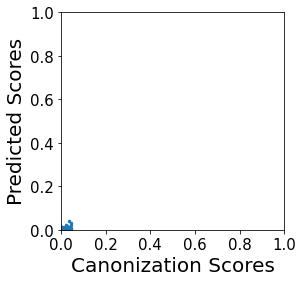

eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 330 columns.
train preds: [-1.51828388e-02 -4.01216708e-02  6.55082846e-03 -1.56574766e-04
  1.12577416e-02  1.09274760e-02 -1.69207454e-02  5.78124868e-03
 -1.31359883e-02 -1.52606415e-02 -3.41405394e-03  2.21666321e-02
 -4.06313911e-02 -8.81176267e-04 -7.33291451e-03 -4.12134500e-03
 -5.16106281e-03 -5.33893630e-02 -1.97231844e-02  5.58897713e-03
  5.96566638e-03 -1.44922538e-02 -6.68428512e-03  3.80022964e-03
 -2.25974210e-02  2.01706236e-04 -3.45268697e-02 -1.52139282e-02
 -1.64774563e-02  2.32181344e-02 -2.23868899e-02  4.59246524e-02
 -8.27491004e-03  2.04806663e-02  1.37270307e-02 -3.63261625e-03
 -2.38611680e-02 -7.58409780e-03  3.79856005e-02 -1.50311626e-02
  1.44838858e-02 -5.93022294e-02  1.49794156e-02 -4.19192947e-02
  1.82359349e-02 -2.51919143e-02 -3.15165184e-02 -2.49235854e-02
 -4.29656766e-02  3.06236371e-03 -7.10616063e-04  3.41660716e-02
 -2

train preds: [-4.25585136e-02  6.39104005e-03 -3.91077017e-04 -3.25446390e-02
  1.22206099e-02  5.65341674e-03 -1.39931561e-02 -2.35680807e-02
 -1.85067777e-03  2.30221283e-02 -4.31404300e-02 -1.80112273e-02
 -3.98066157e-04  2.22118646e-02 -7.42648821e-03 -2.90509267e-03
 -5.64753264e-02 -5.20907342e-03 -5.55504486e-02 -2.10378729e-02
  6.72954600e-03 -7.77738029e-03  1.12650893e-03  2.61859689e-02
 -3.57387438e-02 -1.46863945e-02 -1.80942994e-02  2.43911743e-02
  4.61745448e-02 -9.23449267e-03  2.06315052e-02  1.42990965e-02
 -2.61823330e-02 -8.36177729e-03  3.80875990e-02 -1.67015083e-02
  1.59704406e-02 -6.06481358e-02  1.59008354e-02 -4.42158654e-02
  1.85183994e-02 -3.71332392e-02 -2.77166199e-02  2.87349802e-03
  1.14093840e-04  3.45059484e-02 -5.71214072e-02 -1.06457569e-01
 -6.83545042e-03 -9.60130915e-02 -7.87041560e-02 -3.63525725e-03
 -4.14117351e-02 -1.05313333e-02  1.64885204e-02 -1.26313465e-02
 -2.99249832e-02  9.45296604e-03 -1.16827292e-02  7.00224796e-03
 -1.79560538

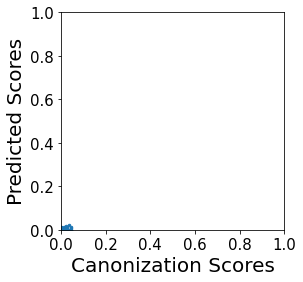

eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 378 columns.
train preds: [-1.4427742e-02 -4.0937655e-02  6.8855537e-03 -4.8612415e-05
 -3.1696785e-02  1.1840933e-02  1.1575003e-02 -1.6475188e-02
  5.8926512e-03 -1.3809378e-02 -2.2496829e-02 -2.5054961e-03
  2.3073576e-02 -4.2116918e-02 -1.7377488e-02 -7.5789302e-04
  2.2641731e-02 -2.8806911e-03 -5.5513505e-02 -5.0608031e-03
 -5.4415297e-02  6.5667951e-03  7.2626956e-03 -1.4609803e-02
 -7.5307889e-03  9.1034436e-04  2.5630081e-02 -1.7420558e-02
  2.4683863e-02 -2.2455851e-02  4.6555575e-02  2.0579198e-02
  1.3970656e-02 -3.8245590e-03 -2.5023311e-02 -7.6407995e-03
  3.8074583e-02 -1.6105894e-02  1.6259467e-02 -5.8055069e-02
  1.6483029e-02 -4.1828144e-02  1.8556198e-02 -2.6260832e-02
 -3.5867546e-02 -2.6645117e-02  2.8999455e-03 -2.4487759e-04
  3.4519155e-02 -2.3761284e-02 -5.3149175e-02 -9.8662741e-02
 -6.8724216e-03 -7.1045913e-02 -3.7501291e-03 -1.21471

train preds: [-1.44368196e-02 -4.31629792e-02  6.70216279e-03 -1.29772653e-03
 -3.25615928e-02  1.13030961e-02 -1.70886144e-02  5.31999441e-03
 -1.43263303e-02 -2.35387422e-02 -1.66795868e-02 -1.75729126e-03
 -4.18039076e-02 -1.72836371e-02  2.24123262e-02 -7.77351949e-03
 -2.47412990e-03 -5.23924548e-03 -5.50003499e-02 -2.15549655e-02
  6.85724709e-03  7.25063216e-03  2.65321881e-03 -2.45371051e-02
  2.58031897e-02 -3.51339392e-02 -1.39893070e-02 -1.82961039e-02
  2.46196557e-02  4.74881530e-02 -8.46576225e-03  2.08265595e-02
  1.39876259e-02 -4.13688878e-03 -2.57505216e-02 -8.85727350e-03
  3.82990353e-02  1.67007577e-02  1.63194519e-02 -4.34321761e-02
  1.74371190e-02 -2.62802970e-02 -3.64477821e-02 -2.65770089e-02
 -4.73140553e-02 -1.02671802e-04  3.42218913e-02 -2.50242166e-02
 -5.55422530e-02 -1.00531511e-01 -9.13928449e-02 -3.40444478e-03
 -4.12022993e-02 -1.04926853e-02  1.63901672e-02 -1.30092492e-02
 -2.97954399e-02 -1.17038842e-02  7.13680871e-03 -1.73522681e-02
 -2.35008597

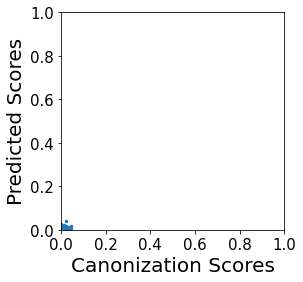

eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 408 columns.
train preds: [-0.01481687 -0.04148994  0.00654678 -0.00058616  0.00843895  0.00990718
 -0.01653004  0.00578443 -0.01306195 -0.02310869 -0.00328426  0.02310085
 -0.04196955 -0.01683664 -0.00053582  0.02208275 -0.00613649 -0.00284923
 -0.00473057 -0.02083478  0.0068555  -0.01592098 -0.00759686  0.00187823
 -0.03535015 -0.01472847 -0.01713446  0.02302167  0.04448048 -0.00825448
  0.0145452  -0.00434408 -0.02655043 -0.00839024  0.03771749 -0.01695641
  0.01636088 -0.05970424  0.01544011  0.01697825 -0.02634968 -0.0366674
 -0.0274146   0.00290676 -0.00037591  0.03386472 -0.02437266 -0.05537058
 -0.10227243 -0.00666496 -0.09225089 -0.07735049 -0.00374609 -0.04121706
 -0.00955077  0.0160253  -0.01228541 -0.03044228  0.0087842   0.00715289
 -0.0174525  -0.01564371 -0.01311153 -0.02136937 -0.0213158  -0.00972733
 -0.02171234 -0.01056174 -0.0318043  -0

train preds: [-1.52076287e-02 -4.34767939e-02  5.96575951e-03  8.61074368e-05
 -3.21263634e-02  1.23326667e-02 -1.61746722e-02 -1.34219760e-02
 -1.69818662e-02  2.33263858e-02 -4.13668267e-02 -1.80927794e-02
  2.20032725e-02 -6.97086705e-03 -5.60693108e-02 -5.28702838e-03
 -5.60503565e-02 -2.09841076e-02  7.13589927e-03  7.41845137e-03
 -1.52478041e-02 -6.98808534e-03  3.05312313e-03 -2.57028304e-02
  2.58846022e-02 -3.60612273e-02 -1.44420397e-02 -1.76742449e-02
  2.47605257e-02 -2.22091507e-02  4.68017049e-02 -8.77988618e-03
  2.05061249e-02  1.44375153e-02 -4.66278009e-03 -2.58580279e-02
  3.86667475e-02 -1.68550033e-02 -6.01579174e-02  1.62079632e-02
 -4.32697386e-02  1.86839942e-02 -3.57568748e-02 -2.77912561e-02
 -4.79216091e-02 -1.62315060e-04  3.35569978e-02 -2.41477415e-02
 -5.50992079e-02 -9.36198235e-02 -7.67894164e-02 -3.26832896e-03
 -4.08643372e-02  1.61426272e-02 -1.31284576e-02 -3.03317830e-02
 -1.16198948e-02 -1.78265572e-02 -1.60045438e-02 -1.40398899e-02
 -2.12144218

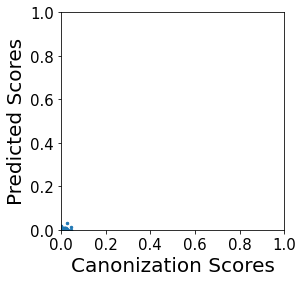

eng xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 868 columns.
train preds: [-0.01254756 -0.01008612 -0.01533659 ... -0.00427233 -0.00074181
 -0.00438945]
validation preds: [-0.00704842 -0.00682764 -0.00358008 ... -0.00921224 -0.0173868
 -0.02231046]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.014, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.045, ValCorr: -0.105
train preds: [-0.01053673 -0.01593307 -0.01576762 ... -0.00665262 -0.00810519
 -0.00743019]
validation preds: [ 0.01502728  0.01082469  0.00512247 ... -0.01452636 -0.01519495
 -0.01045303]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.009, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.096, ValCorr: 0.054
train preds: [-0.02037828 -0.01764293 -0.02195219 ... -0.01246767 -0.00947402
 -0.00481351]
validation preds: [ 0.00625826 -0.00311241 -0.00113678 ... -0.00093919 -0.01128653
 -0.00248642]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.0, ValMAE: 0.017, ValR2: -0.023, ValCorr: 0.104

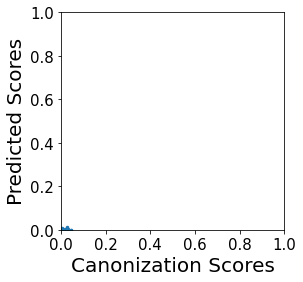

eng xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 868 columns.
train preds: [-0.00850645 -0.00551881 -0.00067767 ... -0.00848269 -0.00474152
 -0.00542243]
validation preds: [-0.00754231 -0.00028825 -0.00966413 ... -0.00900363 -0.01057768
 -0.0199103 ]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.146, ValCorr: -0.202
train preds: [-1.1550079e-02 -6.7501031e-03 -1.1992498e-02 ... -5.2285055e-03
  6.3163279e-05 -2.0729408e-03]
validation preds: [-0.01931    -0.00398541 -0.00073343 ...  0.00711731  0.00705149
 -0.0102809 ]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.001, ValMAE: 0.018, ValR2: -0.135, ValCorr: 0.161
train preds: [-0.01231264 -0.00600069 -0.00969266 ... -0.00680649 -0.00597978
 -0.01103977]
validation preds: [-0.00700081 -0.00642794 -0.00758046 ... -0.00360794 -0.00552989
 -0.00348767]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.017, ValMSE: 0.001, ValMAE: 0.025, V

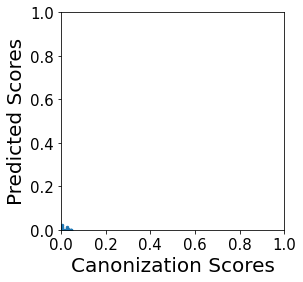

eng xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 868 columns.
train preds: [-0.01053849 -0.00774365 -0.01139404 ...  0.00249038 -0.00561552
  0.00090538]
validation preds: [-1.2512809e-03  2.1470084e-03  3.1776954e-03 ...  2.7743906e-03
 -6.2240842e-03 -8.5611333e-05]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.001, ValMAE: 0.022, ValR2: -0.132, ValCorr: -0.067
train preds: [-0.01425494 -0.01022877 -0.02011462 ... -0.00461133 -0.00640732
 -0.01080238]
validation preds: [ 0.03320647  0.01885002 -0.01546613 ... -0.0051676   0.00358475
 -0.00427619]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.001, ValMAE: 0.019, ValR2: 0.055, ValCorr: 0.239
train preds: [-0.00604262 -0.0080446  -0.00065372 ... -0.00868746 -0.00609542
 -0.00487312]
validation preds: [-0.00219691  0.00641239 -0.00648386 ... -0.01689857 -0.00748322
 -0.00962084]
Fold: 3, TrainMSE: 0.001, TrainMAE: 0.018, ValMSE: 0.001, ValMAE: 0.021, 

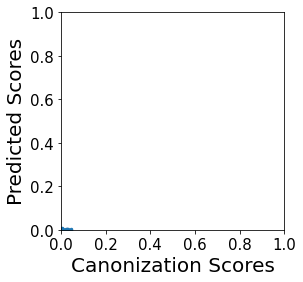

eng xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 868 columns.
train preds: [-0.01402187 -0.01114032 -0.01436584 ... -0.00271211 -0.00962446
  0.00101026]
validation preds: [ 0.0215992   0.02305119  0.0211429  ...  0.00132036 -0.00662523
 -0.00171103]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.016, ValMSE: 0.001, ValMAE: 0.021, ValR2: -0.116, ValCorr: -0.052
train preds: [-0.01593413 -0.00643747 -0.01082583 ... -0.0057913  -0.00168854
 -0.00254109]
validation preds: [-0.00146863  0.00182367  0.00188312 ... -0.01101675 -0.01166406
 -0.01587784]
Fold: 2, TrainMSE: 0.001, TrainMAE: 0.018, ValMSE: 0.001, ValMAE: 0.021, ValR2: 0.039, ValCorr: 0.212
train preds: [-0.01533005 -0.01457641 -0.01976544 ... -0.00370779 -0.0057611
 -0.01797367]
validation preds: [-0.00679155 -0.01196326 -0.01055894 ... -0.00773812 -0.00953456
 -0.00729415]
Fold: 3, TrainMSE: 0.001, TrainMAE: 0.017, ValMSE: 0.001, ValMAE: 0.02, ValR2: -0.0

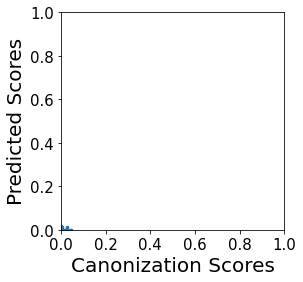

eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 1168 columns.
train preds: [-1.55661069e-02 -3.33132222e-02 -1.29901594e-03 -3.14061381e-02
  1.04790283e-02  8.76434334e-03 -1.80069413e-02  5.87105565e-03
 -1.36762904e-02 -2.26075277e-02 -1.33442832e-02 -3.88625972e-02
 -1.56993512e-02 -4.08588210e-03  1.86383296e-02 -7.38259451e-03
 -7.50389462e-03 -5.46177924e-02 -5.07918838e-03 -5.03801294e-02
 -1.82827935e-02  4.75054234e-03 -1.49083827e-02 -7.55231548e-03
  3.15214042e-03 -2.13207770e-02  1.03466446e-04  2.04034019e-02
 -1.65633950e-02 -1.58013087e-02  1.87654328e-02 -8.86451360e-03
  1.77347679e-02 -3.79412551e-03 -2.31623128e-02 -5.73674636e-03
  3.63269746e-02 -1.22345835e-02  1.12734139e-02  1.11714946e-02
 -3.92807871e-02  1.55008212e-02 -2.56692450e-02 -3.15150954e-02
 -2.33785510e-02 -3.84278521e-02  2.71024811e-03 -2.90991669e-03
 -2.22529694e-02 -5.21732494e-02 -8.03554710e-03 -8.51

train preds: [-1.52400434e-02 -4.24734689e-02  5.95781021e-03 -3.22492607e-02
  1.17049534e-02  1.14893122e-02  5.76282665e-03 -1.51614500e-02
 -2.33877674e-02 -1.64266303e-02 -1.54106342e-03  2.32016761e-02
 -4.17012908e-02 -1.67027377e-02 -5.62888221e-04  2.18982883e-02
 -5.60079068e-02 -6.54513063e-03 -5.43698184e-02  6.45281048e-03
  7.09835440e-03 -1.45617677e-02 -6.66660722e-03  2.12965230e-03
 -2.37621181e-02  1.04890845e-03 -3.52232307e-02 -1.52075496e-02
  2.47441716e-02 -2.29272991e-02  4.48999777e-02  2.04897877e-02
  1.38029233e-02 -3.92758520e-03 -2.52850447e-02  3.86230275e-02
 -1.60197485e-02  1.60025880e-02 -6.05733879e-02 -4.26565856e-02
  1.79516375e-02 -2.69893203e-02 -3.46849114e-02 -2.79003307e-02
 -4.61207256e-02  2.99194711e-03 -8.76758189e-04  3.45120095e-02
 -2.46736128e-02 -5.67896031e-02 -1.01257056e-01 -6.97766803e-03
 -9.46223736e-02 -7.15842992e-02 -3.44741344e-03 -4.16313969e-02
  1.64946262e-02 -1.24085220e-02 -2.79984139e-02  1.03519456e-02
  6.16285997

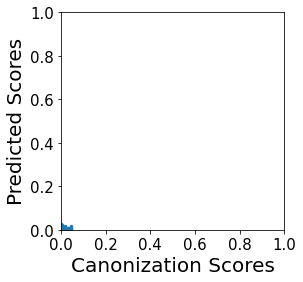

eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 1198 columns.
train preds: [-2.7528562e-02  1.3637313e-02 -2.6193161e-03 -2.5385426e-02
  1.0008679e-02  4.2400532e-03 -1.6124982e-02  3.1755539e-05
 -1.7842527e-02 -1.0312047e-02  2.0533495e-02 -3.6821432e-02
 -1.0636930e-02 -1.0297674e-02 -4.5556735e-02 -1.4857665e-02
 -3.2962583e-02 -4.2749643e-03 -1.7257782e-02 -9.2460830e-03
 -7.0362049e-04 -1.8390447e-02 -2.0970585e-04 -3.4164015e-02
 -2.4793010e-02 -1.8914843e-02  9.4886040e-03 -2.2888297e-02
  4.4362586e-02  5.4640328e-03 -1.7778693e-02 -4.8701204e-03
  1.6572978e-02  5.2120318e-03 -4.6936426e-02  4.5663626e-03
 -2.7528668e-02  1.0343621e-02 -1.8645342e-02 -2.6943725e-02
 -1.5377951e-02 -2.7743261e-02 -3.0011893e-03 -1.4385861e-02
  3.1862132e-02 -2.9481295e-02 -9.9507393e-03 -5.7323791e-02
 -4.0415980e-02 -1.2183691e-02 -3.2743216e-02 -5.2439952e-03
  9.7931437e-03 -1.9730603e-02  1.3

train preds: [-1.49103552e-02 -4.21949625e-02  6.78087445e-03  1.23446211e-02
 -1.62598230e-02  6.32977067e-03 -1.36057241e-02 -2.29929071e-02
 -1.68753718e-03  2.32804660e-02 -4.22269516e-02 -1.76389776e-02
  2.26299260e-02 -7.17271492e-03 -2.91966670e-03 -5.54891005e-02
 -5.06244181e-03 -5.19346185e-02 -1.96094103e-02  6.69526728e-03
  6.98222080e-03 -1.38726430e-02 -6.98310137e-03  1.53174566e-03
  2.66010053e-02 -3.44528630e-02 -1.76777989e-02  2.46699527e-02
 -2.24880818e-02  4.66430485e-02 -8.45247041e-03  2.09735874e-02
  1.47735393e-02 -3.25588207e-03 -7.95907620e-03  3.85965817e-02
 -1.57473162e-02  1.65510923e-02 -5.95284849e-02  1.64283086e-02
 -4.35347930e-02  1.88923404e-02 -3.52249853e-02 -2.60460861e-02
  2.99181556e-03  3.47218327e-02 -2.37124972e-02 -5.48968241e-02
 -1.04002655e-01 -6.37604389e-03 -9.26698223e-02 -7.09680021e-02
 -3.26923514e-03 -4.01147231e-02 -9.90629941e-03 -1.19900554e-02
  9.85836796e-03 -1.12780435e-02  6.79030735e-03 -1.65868551e-02
 -1.56572312

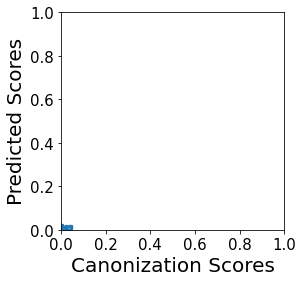

eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 1246 columns.
train preds: [-0.01458532 -0.03969587  0.00508613 -0.03138366  0.00976694  0.01121039
 -0.01695273  0.00537393 -0.01324705 -0.02265203 -0.01450877 -0.00592372
  0.02141182 -0.01612283 -0.00191068  0.02146883 -0.00687224 -0.00554015
 -0.05613785 -0.05403004 -0.01923797  0.00457914  0.00575745 -0.01519638
 -0.00812601  0.001325   -0.02430566 -0.00125991  0.02041772 -0.03406454
 -0.01610309 -0.01733125  0.02326606 -0.02296527  0.04609552 -0.00825411
  0.01762565  0.01416861 -0.00443968 -0.00847031 -0.01544376  0.01367402
 -0.05832893  0.01549506 -0.04009258  0.01619396 -0.02647385 -0.02643721
 -0.04446265  0.03462658 -0.0246077  -0.05663498 -0.10400372 -0.00780733
 -0.07229098 -0.01026398  0.01647283 -0.0118563  -0.01176193  0.00420723
 -0.0173219  -0.01499487 -0.01452728 -0.02305833 -0.01024374  0.0076139
 -0.02235368 -0.01173844 

train preds: [-1.47253620e-02  7.01611908e-03 -8.97305377e-04 -3.21887136e-02
  1.18553545e-02  1.15795126e-02  5.62264258e-03 -1.42684309e-02
 -2.28791125e-02 -1.55228833e-02 -2.99839722e-03  2.34424509e-02
 -4.21734415e-02 -1.41926587e-03 -7.05796806e-03 -3.59637756e-03
 -5.67410514e-02 -5.79567533e-03 -5.42628802e-02 -2.11442616e-02
  6.68177800e-03 -1.54195568e-02  2.42374232e-03 -2.60959510e-02
  2.47894507e-02 -3.55433300e-02 -1.52857378e-02 -1.74359400e-02
  4.65383232e-02 -9.00295284e-03  1.97220612e-02  1.39982039e-02
 -3.72782233e-03 -2.58943569e-02  3.78590450e-02 -1.63752530e-02
  1.57582238e-02 -6.06052950e-02  1.63766220e-02 -4.41108793e-02
  1.87094510e-02 -2.64761504e-02 -3.61630544e-02 -4.78943363e-02
  2.67278450e-03 -4.52374894e-04  3.45037803e-02 -2.45760418e-02
 -5.66349700e-02 -1.06803402e-01 -6.88245194e-03 -9.51187387e-02
 -7.64100552e-02 -4.18285746e-03 -4.10680175e-02 -1.09018311e-02
  1.62246842e-02 -2.98444610e-02  9.83887445e-03 -1.19276466e-02
  6.69329893

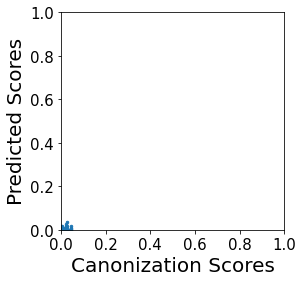

eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 1276 columns.
train preds: [-4.32377383e-02  6.01234846e-03 -5.96975733e-04  1.15074152e-02
  1.12943342e-02  5.78231411e-03 -1.39563307e-02 -2.33700369e-02
 -2.22847797e-03 -4.24960256e-02 -1.78116634e-02 -5.89074509e-04
  2.23254729e-02 -7.41211511e-03 -5.70329092e-02 -5.50131546e-03
 -5.55281900e-02 -2.09896341e-02  6.75602350e-03 -1.53980721e-02
 -7.87427183e-03  6.33002142e-04  2.58770697e-02 -3.56272459e-02
 -1.49301812e-02 -1.75507404e-02  2.47135777e-02 -2.27432624e-02
  4.68010418e-02 -8.98681022e-03  2.07994375e-02  1.44005278e-02
 -2.66976673e-02 -8.59338045e-03  3.81599963e-02 -1.69692524e-02
  1.57054234e-02 -4.41245846e-02 -2.66554710e-02 -3.66058834e-02
 -2.77031362e-02  2.65092496e-03  7.06920328e-05  3.41239907e-02
 -5.70965260e-02 -1.05815016e-01 -6.57287706e-03 -9.67725143e-02
 -7.69801140e-02 -3.51872458e-03 -4.12126

train preds: [-0.00761937  0.00528378 -0.02479286 -0.0017688   0.00200672 -0.01757769
 -0.00946507 -0.01548409 -0.00771426 -0.00326815 -0.03066457 -0.02009593
  0.0056665  -0.00248939 -0.01070623 -0.04274293 -0.0084667  -0.02933072
 -0.01018862  0.00687672 -0.00567303 -0.01359889 -0.00305473  0.00038739
 -0.01989202 -0.00780047 -0.02151621 -0.01055079 -0.01569211  0.02304554
 -0.00194877  0.00329495  0.00969332 -0.00322876 -0.01921739  0.01586148
 -0.01229726  0.00488403 -0.04684735  0.01000677 -0.01807259 -0.00261806
 -0.02104891 -0.02175411 -0.00807257  0.00619652 -0.00833887  0.0158846
 -0.02540735 -0.04754927 -0.07793938 -0.01753303 -0.08389472 -0.00755957
 -0.020968   -0.00475087  0.00994617 -0.00900316 -0.01889724  0.00861239
 -0.01510455 -0.01741562 -0.0101161  -0.01328095 -0.01164433 -0.01177898
  0.00595573 -0.00347495 -0.00997076 -0.02892112 -0.01886795 -0.01962537
  0.01063322 -0.01729432  0.00835741 -0.04462417 -0.01129329 -0.02492833
 -0.00670505  0.00092604 -0.02308876 -0

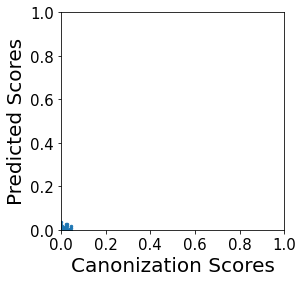

eng xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 1168 columns.
train preds: [-0.01574106 -0.01574106 -0.01574106 ... -0.00114071 -0.00114071
 -0.00114071]
validation preds: [-0.02433509 -0.02433509 -0.02433509 ...  0.02336053  0.02336053
  0.02336053]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.001, ValMSE: 0.001, ValMAE: 0.022, ValR2: -0.371, ValCorr: -0.041
train preds: [-0.01524723 -0.01524723 -0.01524723 ... -0.00032445 -0.00032445
 -0.00032445]
validation preds: [-0.00994257 -0.00994257 -0.00994257 ... -0.00371484 -0.00371484
 -0.00371484]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.001, ValMAE: 0.022, ValR2: -0.148, ValCorr: 0.131
train preds: [-0.01515151 -0.01515151 -0.01515151 ...  0.00502534  0.00502534
  0.00502534]
validation preds: [ 0.00995164  0.00995164  0.00995164 ... -0.02773558 -0.02791604
 -0.02773558]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.001, ValMAE: 0.019, ValR2: -0.05

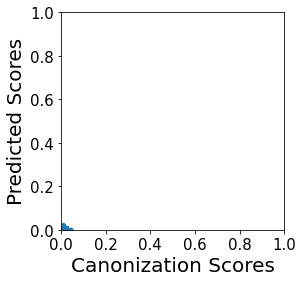

eng xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 1198 columns.
train preds: [-0.01526488 -0.01526488 -0.01526488 ...  0.00112698  0.00112698
  0.00112698]
validation preds: [ 0.00971804  0.00971804  0.00971804 ... -0.03745585 -0.03745585
 -0.03745585]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.001, ValMAE: 0.024, ValR2: -0.262, ValCorr: 0.029
train preds: [-0.04368485 -0.04368485 -0.04368485 ... -0.00259448 -0.00259448
 -0.00259448]
validation preds: [-0.03911396 -0.03911396 -0.03911396 ... -0.01908978 -0.01908978
 -0.01908978]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.001, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.236, ValCorr: 0.13
train preds: [-0.01520186 -0.01520186 -0.01520186 ... -0.00017246 -0.00017246
 -0.00017246]
validation preds: [-0.03115775 -0.03115775 -0.03115775 ...  0.01178418  0.01178418
  0.01178418]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.0, ValMAE: 0.017, ValR2: -0.

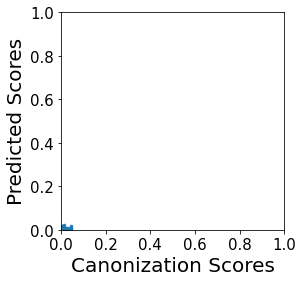

eng xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 1246 columns.
train preds: [-0.01471057 -0.01471057 -0.01471057 ... -0.00113471 -0.00113471
 -0.00113471]
validation preds: [-0.0250862  -0.0250862  -0.0250862  ... -0.00202104 -0.00202104
 -0.00202104]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.001, ValMSE: 0.001, ValMAE: 0.027, ValR2: -0.732, ValCorr: -0.122
train preds: [-0.01360944 -0.01360944 -0.01360944 ... -0.00028769 -0.00028769
 -0.00028769]
validation preds: [-0.01674297 -0.01674297 -0.01674297 ... -0.0359088  -0.0359088
 -0.0359088 ]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.001, ValMSE: 0.001, ValMAE: 0.026, ValR2: -0.242, ValCorr: 0.079
train preds: [-0.04398571 -0.04398571 -0.04398571 ... -0.00058698 -0.00058698
 -0.00058698]
validation preds: [-0.00590596 -0.00590596 -0.00590596 -0.00590596 -0.00590596 -0.00590596
 -0.00590596 -0.00590596 -0.00590596 -0.00590596 -0.00619497 -0.00619497
 -0.00

train preds: [-0.01157852 -0.01157852 -0.01157852 ... -0.00820666 -0.00820666
 -0.00820666]
validation preds: [-0.00888467 -0.00888467 -0.00888467 ... -0.00291704 -0.00291704
 -0.00291704]
Fold: 4, TrainMSE: 0.0, TrainMAE: 0.007, ValMSE: 0.001, ValMAE: 0.023, ValR2: -0.249, ValCorr: -0.01
train preds: [-0.01198723 -0.01198723 -0.01198723 ... -0.00412358 -0.00412358
 -0.00412358]
validation preds: [-0.00797127 -0.00797127 -0.00797127 ... -0.01812962 -0.01812962
 -0.01812962]
Fold: 5, TrainMSE: 0.0, TrainMAE: 0.007, ValMSE: 0.001, ValMAE: 0.017, ValR2: -0.144, ValCorr: 0.251
TrainMSE: 0.0, TrainRMSE: 0.004, TrainMAE: 0.003, TrainR2: 0.95, TrainCorr: 0.981, ValMSE: 0.001, ValRMSE: 0.03, ValMAE: 0.023, ValR2: -0.319, ValCorr: 0.037, ValCorrPValue: 0.325

---------------------------------------------------



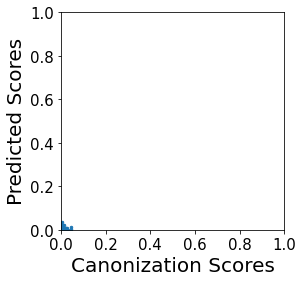

eng xgboost chunk_and_copied_book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None
Dropped 1276 columns.
train preds: [-0.01850464 -0.01850464 -0.01850464 ... -0.00158614 -0.00084096
 -0.00158614]
validation preds: [-7.7349629e-05 -7.7349629e-05 -8.2253240e-04 ... -5.9345905e-03
 -5.9345905e-03 -5.9345905e-03]
Fold: 1, TrainMSE: 0.0, TrainMAE: 0.01, ValMSE: 0.001, ValMAE: 0.022, ValR2: -0.156, ValCorr: 0.061
train preds: [-1.4639119e-02 -1.4900221e-02 -1.5577244e-02 ...  2.9099532e-04
  2.2697957e-04  3.5813420e-05]
validation preds: [-0.00901642 -0.01049418 -0.00891382 ... -0.02118881 -0.01976502
 -0.01721068]
Fold: 2, TrainMSE: 0.0, TrainMAE: 0.0, ValMSE: 0.001, ValMAE: 0.02, ValR2: -0.191, ValCorr: 0.142
train preds: [-0.01291316 -0.01546036 -0.01546036 ... -0.00211455 -0.00211455
 -0.00156954]
validation preds: [-0.00361312 -0.00362483 -0.00362483 ...  0.0110252   0.0110252
  0.01020326]
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.

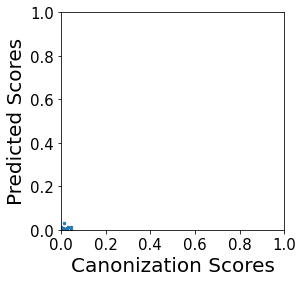

In [13]:
'''
Run Regression
'''
results = []
param_dict = "regression" 
for lang in [lang]:
    if param_dict == "regression":
        param_dir = regression_params
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in param_dir['model']:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = Regression(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_mse, mean_train_rmse, mea  n_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
                        #except Exception as e:
#                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
#                             print(e)
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
"mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
"mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
results_df.to_csv(results_dir + lang + '_' + 'regression_' + senti_tool + param_dict + ".csv", index=False)